
02_model_training.ipynb : Modélisation et Tracking MLflow

 **Objectif :** Entraîner une baseline et un modèle avancé, en gérant le déséquilibre des classes et en traquant les performances (notamment le coût métier) via MLflow.



In [17]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import sys
import os
import lightgbm as lgb

# Ajout du chemin src pour importer nos modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from model_utils import (
    prepare_data_for_training, 
    train_cv_and_log, 
    plot_business_cost_threshold,
    optimize_hyperparameters_optuna
)

from metrics import custom_business_cost

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Configuration MLflow
EXPERIMENT_NAME = "Credit_Scoring_Final"
mlflow.set_tracking_uri("file:../mlruns")

# ## 1. Chargement et Préparation des Données
# La fonction `prepare_data_for_training` charge les CSV, **nettoie les noms de colonnes** (pour éviter l'erreur JSON LightGBM), gère les infinis, et effectue le split stratifié.
PATH_TRAIN = '../datasets/final/train_enriched.csv'
PATH_LABELS = '../datasets/final/train_labels.csv'

# X_train et X_val sont déjà nettoyés ici !
X_train, X_val, y_train, y_val = prepare_data_for_training(PATH_TRAIN, PATH_LABELS)

print(f"Données chargées. Train shape: {X_train.shape}")

Chargement des données...
Nettoyage des noms de colonnes...
Split Train/Validation (Stratifié)...
Données chargées. Train shape: (246008, 1845)


In [ ]:
# ## 2. Étape 3 : Validation Croisée (Baseline vs LightGBM)
# Nous comparons la robustesse des modèles sur 5 plis (folds).
# --- MODELE 1 : BASELINE (Régression Logistique) ---
# Pipeline nécessaire pour gérer les NaN
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(C=1.0, class_weight='balanced', max_iter=500))
])

print("\n--- Cross-Validation: Baseline ---")
# On utilise X_train pour la CV (le set de validation final X_val est gardé pour l'optimisation du seuil)
model_lr_cv, cost_lr = train_cv_and_log(
    pipe_lr, X_train, y_train, EXPERIMENT_NAME, "CV_Baseline_LogReg"
)

c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/12/06 18:45:25 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Scoring_Final' does not exist. Creating a new experiment.



--- Cross-Validation: Baseline ---
--- Démarrage Cross-Validation (5 folds) pour CV_Baseline_LogReg ---


c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
   

  >> Moyenne CV: Coût Métier=25061.8 | AUC=0.771
Re-training sur l'ensemble du dataset...


c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/12/06 19:12:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/06 19:12:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Cross-Validation: LightGBM ---
--- Démarrage Cross-Validation (5 folds) pour CV_LightGBM_Default ---
  >> Moyenne CV: Coût Métier=25370.8 | AUC=0.776
Re-training sur l'ensemble du dataset...


2025/12/06 19:38:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/06 19:38:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


IndexError: index 305371 is out of bounds for axis 0 with size 246008

In [ ]:
# --- MODELE 2 : LightGBM (Avancé) ---
# LightGBM gère les NaN nativement
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    class_weight='balanced',
    n_jobs=3,
    random_state=42,
    verbose=-1
)

print("\n--- Cross-Validation: LightGBM ---")

model_lgbm_cv, cost_lgbm = train_cv_and_log(
    lgbm, X_train, y_train, EXPERIMENT_NAME, "CV_LightGBM_Default"
)


In [3]:
# 1. Échantillonnage (20% pour aller vite et éviter saturation RAM)
X_sample = X_train.sample(frac=0.2, random_state=42)
y_sample = y_train[X_sample.index]

print("Lancement de l'optimisation Optuna...")

# 2. Recherche des meilleurs hyperparamètres
best_params = optimize_hyperparameters_optuna(
    X_sample, 
    y_sample, 
    experiment_name=EXPERIMENT_NAME, 
    n_trials=50
)

c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
[I 2025-12-06 22:26:10,025] A new study created in memory with name: no-name-8e5b0700-98d6-40e1-ac46-596411223407


Lancement de l'optimisation Optuna...
--- Optimisation Optuna (50 essais) ---


[I 2025-12-06 22:29:00,709] Trial 0 finished with value: 0.7467684089072483 and parameters: {'n_estimators': 967, 'learning_rate': 0.02358638948578916, 'num_leaves': 33, 'max_depth': 10, 'reg_alpha': 4.976531821229218e-08, 'reg_lambda': 0.08007881145384768, 'colsample_bytree': 0.6403425631543213, 'subsample': 0.8411805874350293}. Best is trial 0 with value: 0.7467684089072483.
[I 2025-12-06 22:31:45,078] Trial 1 finished with value: 0.7283523142312079 and parameters: {'n_estimators': 789, 'learning_rate': 0.08504940288031264, 'num_leaves': 50, 'max_depth': 13, 'reg_alpha': 0.0210618403440351, 'reg_lambda': 2.186584354112155e-06, 'colsample_bytree': 0.5279110362915354, 'subsample': 0.8019496001993168}. Best is trial 0 with value: 0.7467684089072483.
[I 2025-12-06 22:33:44,544] Trial 2 finished with value: 0.7348937856900938 and parameters: {'n_estimators': 441, 'learning_rate': 0.0695629689144442, 'num_leaves': 35, 'max_depth': 15, 'reg_alpha': 1.0360846078580993e-05, 'reg_lambda': 2.22

Meilleurs params: {'n_estimators': 967, 'learning_rate': 0.02358638948578916, 'num_leaves': 33, 'max_depth': 10, 'reg_alpha': 4.976531821229218e-08, 'reg_lambda': 0.08007881145384768, 'colsample_bytree': 0.6403425631543213, 'subsample': 0.8411805874350293}


In [11]:
# 1. On définit MANUELLEMENT les meilleurs paramètres trouvés précédemment (Trial 4)
print("Utilisation des paramètres manuels ...")
#meilleurs paramètres trouvés jusqu'à présent
fixed_params = {
    'n_estimators': 536,
    'learning_rate': 0.0146,       # Apprentissage lent et précis
    'num_leaves': 53,
    'max_depth': 11,
    'reg_alpha': 6.132,            # Forte régularisation L1 (Nettoie le bruit)
    'reg_lambda': 1.45e-07,        # Régularisation L2 faible
    'colsample_bytree': 0.915,
    'subsample': 0.977
}

Utilisation des paramètres manuels ...


In [12]:
# 3. Entraînement du modèle final avec les paramètres gagnants
print("\nEntraînement du modèle final...")
best_lgbm = LGBMClassifier(
    **fixed_params,          # On injecte les paramètres trouvés par Optuna
    class_weight='balanced',
    n_jobs=-1,              # Utilise tous les cœurs
    random_state=42,
    verbose=1
)

# 4. Optimisation du seuil métier (Sur le set de validation complet)
best_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=200)]
)
print("\n--- Évaluation du Modèle ---")
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC Score : {auc_score:.4f}")


Entraînement du modèle final...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.331832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211504
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 1837
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.772755	valid_0's binary_logloss: 0.563753
[400]	valid_0's auc: 0.784377	valid_0's binary_logloss: 0.534445
Did not meet early stopping. Best iteration is:
[536]	valid_0's auc: 0.787195	valid_0's binary_logloss: 0.521942

--- Évaluation du Modèle ---
ROC AUC Score : 0.7872


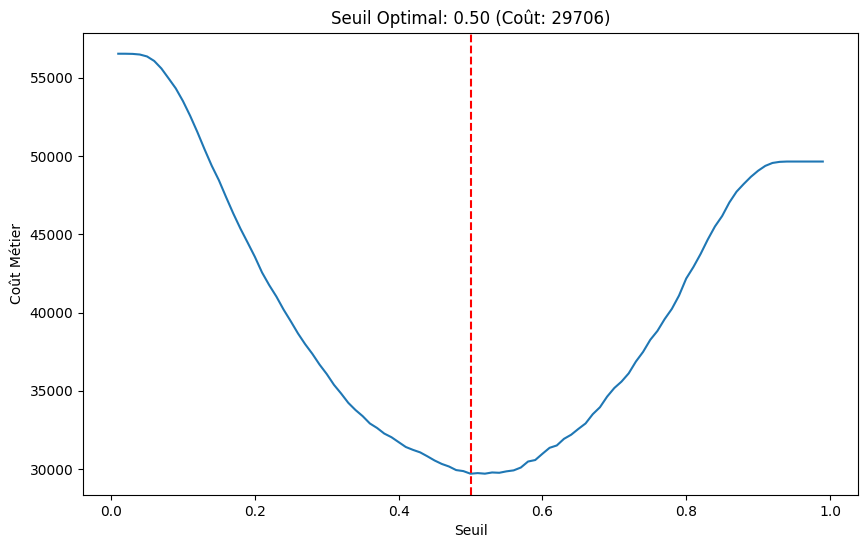

2025/12/06 23:44:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



>>> MODÈLE FINAL OPTIMISÉ <<<
Seuil de décision : 0.500


2025/12/06 23:44:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [19]:
fig, best_thresh = plot_business_cost_threshold(y_val, y_val_proba)
plt.show()

print(f"\n>>> MODÈLE FINAL OPTIMISÉ <<<")
print(f"Seuil de décision : {best_thresh:.3f}")

# Sauvegarde finale
with mlflow.start_run(run_name="Final_Model_Optuna"):
    mlflow.log_params(fixed_params)
    mlflow.log_param("optimal_threshold", best_thresh)
    mlflow.log_figure(fig, "business_cost_curve.png")
    mlflow.sklearn.log_model(best_lgbm, "model_final")

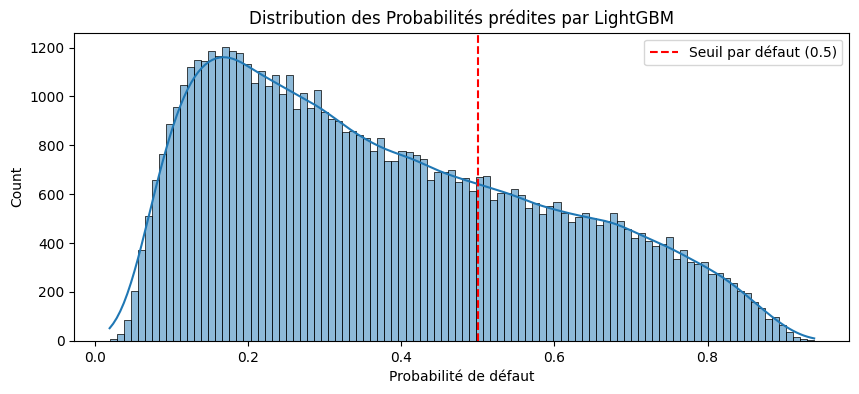

Probabilité Min: 0.0188
Probabilité Moyenne: 0.3794
Probabilité Max: 0.9393

--- RÉSULTAT CORRIGÉ ---
Seuil Optimal Réel : 0.505
Coût Minimum : 29661
Coût avec seuil 0.50 : 29706
Économie réalisée : 45 points

--- Performance au Seuil Optimal ---
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     56538
           1       0.19      0.69      0.30      4965

    accuracy                           0.74     61503
   macro avg       0.58      0.72      0.57     61503
weighted avg       0.90      0.74      0.80     61503



In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Récupérer les probas du modèle final (déjà entraîné)
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]

# 2. DIAGNOSTIC : L'Histogramme des probabilités
# C'est LE graphique le plus important pour comprendre votre modèle
plt.figure(figsize=(10, 4))
sns.histplot(y_val_proba, bins=100, kde=True)
plt.axvline(0.5, color='r', linestyle='--', label="Seuil par défaut (0.5)")
plt.title("Distribution des Probabilités prédites par LightGBM")
plt.xlabel("Probabilité de défaut")
plt.legend()
plt.show()

print(f"Probabilité Min: {y_val_proba.min():.4f}")
print(f"Probabilité Moyenne: {y_val_proba.mean():.4f}")
print(f"Probabilité Max: {y_val_proba.max():.4f}")

# 3. Recherche Granulaire du Seuil
# On cherche très précisément entre 0.01 et 0.50 (la zone critique)
thresholds = np.arange(0.01, 0.95, 0.005) 
costs = []

for thresh in thresholds:
    y_pred_t = (y_val_proba >= thresh).astype(int)
    cost = custom_business_cost(y_val, y_pred_t) # Assurez-vous que y_val est bien le bon format (Series ou array)
    costs.append(cost)

# Trouver le min
min_cost_index = np.argmin(costs)
real_best_thresh = thresholds[min_cost_index]
min_cost_val = costs[min_cost_index]

print(f"\n--- RÉSULTAT CORRIGÉ ---")
print(f"Seuil Optimal Réel : {real_best_thresh:.3f}")
print(f"Coût Minimum : {min_cost_val}")

# 4. Vérification d'impact
# Comparons le coût à 0.5 vs le coût au seuil optimal
y_pred_05 = (y_val_proba >= 0.5).astype(int)
cost_05 = custom_business_cost(y_val, y_pred_05)

print(f"Coût avec seuil 0.50 : {cost_05}")
print(f"Économie réalisée : {cost_05 - min_cost_val} points")

# 5. Rapport de classification final
y_pred_final = (y_val_proba >= real_best_thresh).astype(int)
print("\n--- Performance au Seuil Optimal ---")
print(classification_report(y_val, y_pred_final))